From http://ipython-books.github.io/featured-03/
Creating a route planner for road network in Python

In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import json
import smopy
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = mpl.rcParams['savefig.dpi'] = 300

We load the data (a Shapefile dataset) with NetworkX. 
This dataset contains detailed information about the primary roads in California. 
NetworkX's read_shp function returns a graph, where each node is a geographical position, 
and each edge contains information about the road linking the two nodes.

note: replaced tutorial shapefile (tl_2013_06_prisecroads.shp) with latest version from Census (http://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2016&layergroup=Roads)

In [3]:
#this will error out unless GDAL is installed correctly
#see http://gis.stackexchange.com/questions/9553/installing-gdal-and-ogr-for-python?newreg=b2260dd41b294b6f9efa5c81fd31db17
g = nx.read_shp('Road files/data/tl_2016_06_prisecroads.shp')

This graph is not necessarily connected, but we need a connected graph in order to compute shortest paths. 
Here, we take the largest connected subgraph using the connected_component_subgraphs function.

In [4]:
#tutorial assumes subgraphs are returned in descending size, that's not true, so have to find the biggest
sg_all = list(nx.connected_component_subgraphs(g.to_undirected()))

max_len = -1
sg_final = sg_all[0]
for sg in sg_all:
    x = len(sg)
    if x > max_len:
        max_len = x
        sg_final = sg
        
sg = sg_final
len(sg)

590

We define two positions (with the latitude and longitude). We will find the shortest path between these two positions.

In [5]:
pos0 = (36.6026, -121.9026)
pos1 = (34.0569, -118.2427)

In [6]:
"""
    Each edge in the graph contains information about the road, including a list of points along this road. 
    We first create a function that returns this array of coordinates, for any edge in the graph.
"""

def get_path(n0, n1):
    """If n0 and n1 are connected nodes in the graph, this function
    return an array of point coordinates along the road linking
    these two nodes."""
    return np.array(json.loads(sg[n0][n1]['Json'])['coordinates'])

In [7]:
"""
    We will notably use the road path to compute its length. 
    We first need to define a function that computes the distance between any two points in geographical coordinates. 
    This function has been found in StackOverflow. 
    http://stackoverflow.com/questions/8858838/need-help-calculating-geographical-distance
"""

EARTH_R = 6372.8
def geocalc(lat0, lon0, lat1, lon1):
    """Return the distance (in km) between two points in 
    geographical coordinates."""
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    dlon = lon0 - lon1
    y = np.sqrt(
        (np.cos(lat1) * np.sin(dlon)) ** 2
         + (np.cos(lat0) * np.sin(lat1) 
         - np.sin(lat0) * np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    return EARTH_R * c

In [8]:
"""
    Now, we define a function computing a path's length.
"""

def get_path_length(path):
    return np.sum(geocalc(path[1:,0], path[1:,1],
                          path[:-1,0], path[:-1,1]))

In [9]:
"""
    Now, we update our graph by computing the distance between any two connected nodes. 
    We add this information in the distance attribute of the edges.
"""

for n0, n1 in sg.edges_iter():
    path = get_path(n0, n1)
    distance = get_path_length(path)
    sg.edge[n0][n1]['distance'] = distance

In [10]:
"""
    The last step before we can find the shortest path in the graph, 
    is to find the two nodes in the graph that are closest to the two requested positions.
"""

nodes = np.array(sg.nodes())
# Get the closest nodes in the graph.
pos0_i = np.argmin(np.sum((nodes[:,::-1] - pos0)**2, axis=1))
pos1_i = np.argmin(np.sum((nodes[:,::-1] - pos1)**2, axis=1))

In [11]:
"""
    Now, we use NetworkX's shortest_path function to compute the shortest path between our two positions. 
    We specify that the weight of every edge is the length of the road between them.
"""

# Compute the shortest path.
path = nx.shortest_path(sg, 
                        source=tuple(nodes[pos0_i]), 
                        target=tuple(nodes[pos1_i]),
                        weight='distance')
len(path)

20

In [12]:
"""
    The itinerary has been computed. 
    The path variable contains the list of edges that form the shortest path between our two positions. 
    Now, we can get information about the itinerary with Pandas. 
    The dataset has a few fields of interest, including the name and type (State, Interstate, etc.) of the roads.
"""

roads = pd.DataFrame([sg.edge[path[i]][path[i + 1]] 
                      for i in range(len(path) - 1)], 
                     columns=['FULLNAME', 'MTFCC', 
                              'RTTYP', 'distance'])
roads

,FULLNAME,MTFCC,RTTYP,distance
0,State Rte 1,S1200,S,100.658034
1,State Rte 1,S1200,S,33.425344
2,Cabrillo Hwy,S1200,M,4.399051
3,State Rte 1,S1200,S,12.400391
4,State Rte 1,S1200,S,33.954323
5,State Rte 1,S1200,S,2.742541
6,el Camino Real,S1200,M,0.369877
7,el Camino Real,S1200,M,0.006022
8,el Camino Real,S1200,M,0.445051
9,el Camino Real,S1200,M,3.184544


In [13]:
"""
    Here is the total length of this itinerary.
"""

roads['distance'].sum()

509.9667154279074

In [14]:
"""
    Finally, let display the itinerary on the map. We first retrieve the map with Smopy.
"""
map = smopy.Map(pos0, pos1, z=7, margin=.1)

In [15]:
"""
    Our path contains connected nodes in the graph. 
    Every edge between two nodes is characterized by a list of points (constituting a part of the road). 
    Therefore, we need to define a function that concatenates the positions along every edge in the path. 
    A difficulty is that we need to concatenate the positions in the right order along our path. 
    We choose the order based on the fact that the last point in an edge needs to be close to the first point in the next edge.
"""

def get_full_path(path):
    """Return the positions along a path."""
    p_list = []
    curp = None
    for i in range(len(path)-1):
        p = get_path(path[i], path[i+1])
        if curp is None:
            curp = p
        if np.sum((p[0]-curp)**2) > np.sum((p[-1]-curp)**2):
            p = p[::-1,:]
        p_list.append(p)
        curp = p[-1]
    return np.vstack(p_list)

In [16]:
"""
    We convert the path in pixels in order to display it on the Smopy map.
"""
linepath = get_full_path(path)
x, y = map.to_pixels(linepath[:,1], linepath[:,0])

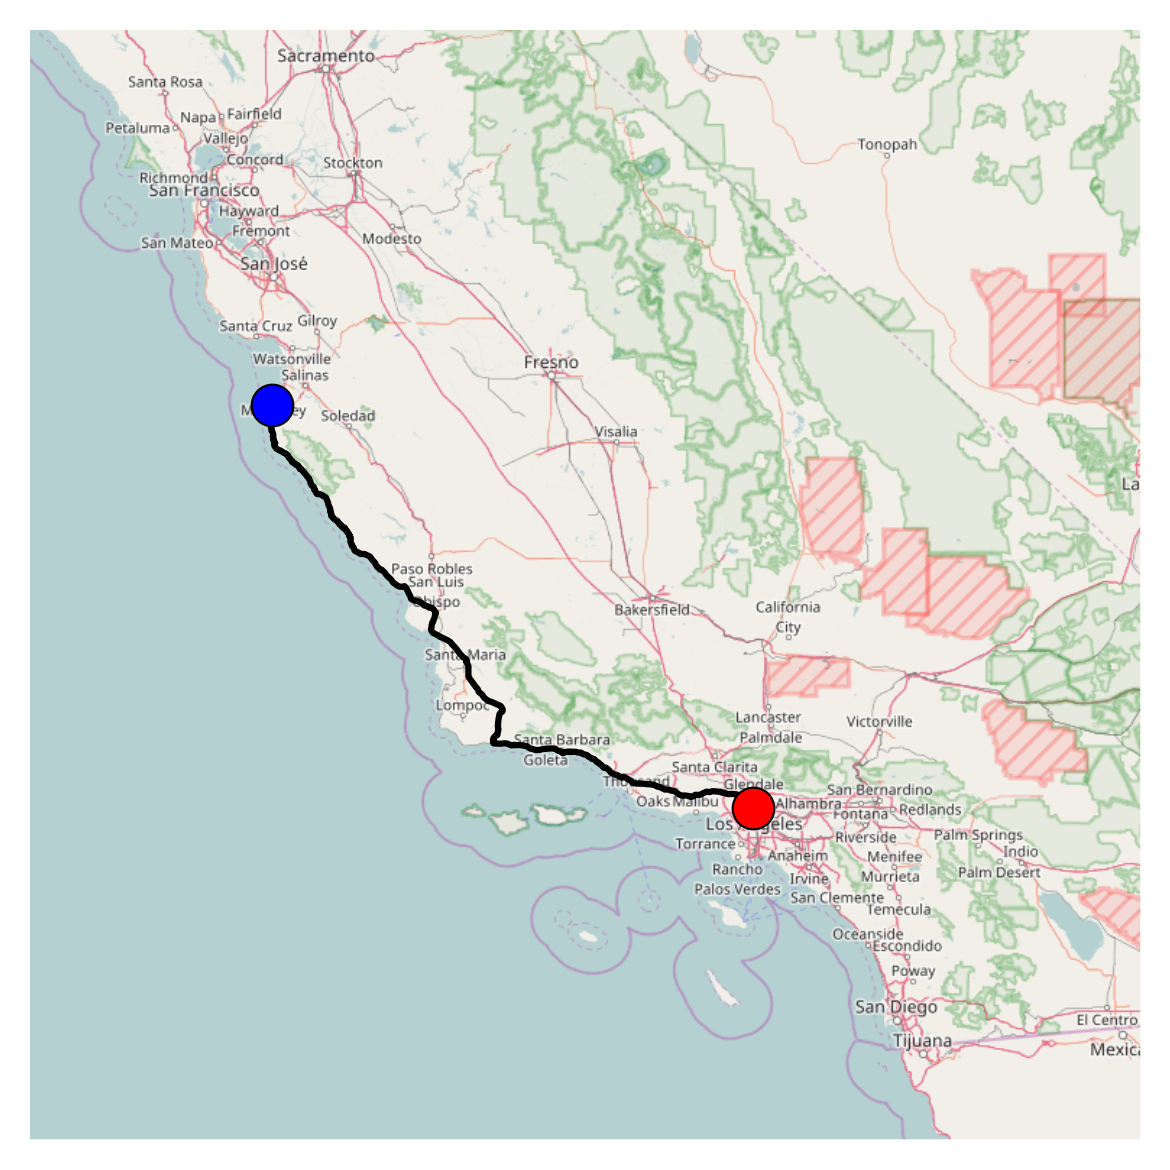

In [17]:
"""
    Finally, we display the map, with our two positions and the computed itinerary between them.
"""
plt.figure(figsize=(6,6));
map.show_mpl();
# Plot the itinerary.
plt.plot(x, y, '-k', lw=1.5);
# Mark our two positions.
plt.plot(x[0], y[0], 'ob', ms=10);
plt.plot(x[-1], y[-1], 'or', ms=10);